# Milky Way Mapper's Galaxy

In this notebook, you're going to explore the Milky Way galaxy as probed by the most recently published Milky Way Mapper dataset from the APOGEE spectrograph (SDSS DR19). This notebook was developed by referencing notebooks by Danny Horta, Emily Griffith, and Henry Leung, and Ted Mackereth.

You can read more about that dataset at: https://www.sdss.org/dr19/mwm/ or in papers like https://ui.adsabs.harvard.edu/abs/2025arXiv250707093S/abstract or https://ui.adsabs.harvard.edu/abs/2025AJ....170...96M/abstract

In [1]:
#Import some things
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits, ascii
from astropy.table import Table, Column, join, vstack
from astropy.coordinates import SkyCoord
from tensorflow import keras

In [2]:
#load in the data (may have to change this for wherever you downloaded your file)
#in google colab you can get the file using
!wget https://dr19.sdss.org/sas/dr19/spectro/astra/0.6.0/summary/astraAllStarASPCAP-0.6.0.fits.gz



--2025-12-06 01:58:55--  https://dr19.sdss.org/sas/dr19/spectro/astra/0.6.0/summary/astraAllStarASPCAP-0.6.0.fits.gz
Resolving dr19.sdss.org (dr19.sdss.org)... 155.101.19.134
Connecting to dr19.sdss.org (dr19.sdss.org)|155.101.19.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1171102556 (1.1G) [application/octet-stream]
Saving to: ‘astraAllStarASPCAP-0.6.0.fits.gz’

astraAllStarASPCAP- 100%[===================>]   1.09G  28.2MB/s    in 42s     

2025-12-06 01:59:39 (26.4 MB/s) - ‘astraAllStarASPCAP-0.6.0.fits.gz’ saved [1171102556/1171102556]



In [3]:
filename='astraAllStarASPCAP-0.6.0.fits.gz'
tb = fits.open(filename)
header=tb[2].header
data = tb[2].data

In [4]:
header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2068 / length of dimension 1                          
NAXIS2  =              1095480 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  396 / number of table fields                         
                                                                                
        Metadata                                                                
                                                                                
INSTRMNT= 'APOGEE  '           / Instrument                                     
PIPELINE= 'ASPCAP  '        

In [5]:
# get rid of stars with negative distances
#mask_gaia = (data['zgr_plx']>0)
data_masked=data

In [6]:
# Age option 3 APOKASC-3 Pinsonneault et al. 2025
#Reading in the table, making sure all the tables have a column named Age in Gyr
# and that every star in the table has an Age
apokasc3raw= Table.read("Pinsonneault2025.txt", format="ascii.cds")
#in this case there were two age columns, one for Red Clump and one for Red Giant Branch so we combine them
ageRC=np.array(apokasc3raw['AgeRC']*(apokasc3raw['EvolState']=='RC'))
rcnans=np.isnan(ageRC) #removing nans from this version of the table.
ageRC[rcnans]=0
ageRGB=np.array(apokasc3raw['AgeRGB']*(apokasc3raw['EvolState']=='RGB'))
rgbnans=np.isnan(ageRGB) #removing nans from this version of the table.
ageRGB[rgbnans]=0
apokasc3raw['Age']=(ageRC+ageRGB)

hasagea3=np.where((apokasc3raw['Age']==apokasc3raw['Age']) & (apokasc3raw['Age']>0.1))
apokasc3=apokasc3raw[hasagea3]
apokasc3

KIC,EvolState,ESSource,CatTab,SeisSource,SpecSource,NNumax,NDNu,Nquar,Numax,e_Numax,DNu,e_DNu,FDNu,e_FDNu,FNumax,Mass,e_Mass,Radius,e_Radius,logg-Seis,e_logg-Seis,Teff,e_Teff,logg-Spec,e_logg-Spec,[Fe/H],e_[Fe/H],[a/Fe],e_[a/Fe],[C/Fe],e_[C/Fe],[N/Fe],e_[N/Fe],InvRGaia,e_InvRGaia,AgeCat,AgeRGB,E_AgeRGB,e_AgeRGB,AgeRC,E_AgeRC,e_AgeRC,vsini,alphaCat,GaiaDR3,2MASS,Age
,,,,,,,,,uHz,uHz,uHz,uHz,,,,solMass,solMass,Rsun,Rsun,dex(cm / s2),dex(cm / s2),K,K,dex(cm / s2),dex(cm / s2),dex(---),dex(---),dex(---),dex(---),dex(---),dex(---),dex(---),dex(---),,,,Gyr,Gyr,Gyr,Gyr,Gyr,Gyr,km / s,,,,
int64,str7,str4,str8,str4,str4,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float64,float64,float64,float64,float64,float64,float64,str5,int64,str23,float64
893214,RGB,Seis,Gold,WAvg,DR17,8,5,15,40.5841,0.2874,4.3254,0.0289,1.0277,0.005,0.9976,1.4404,0.0602,11.0014,0.2055,2.5146,0.0042,4718.9233,44.7811,2.4559,0.058,-0.2617,0.058,0.0815,0.022,-0.0626,0.0135,0.2483,0.0164,0.082389,0.002866,RGB,2.8815,0.298,-0.2639,2.8815,0.298,-0.2639,0.0,Apoor,2050237616959273728,2MASS J19245967+3638183,2.8815
1026180,RC,Spec,Gold,WAvg,DR17,8,5,4,35.6089,0.2338,3.9208,0.0265,0.9972,0.005,0.9936,1.5334,0.0633,12.2361,0.2278,2.4512,0.0039,4576.1016,40.5161,2.4066,0.058,0.2741,0.058,0.0215,0.022,0.0568,0.0084,0.3647,0.0107,0.085599,0.002161,RC,--,--,--,3.1325,0.2754,-0.1905,0.0,Apoor,2050237174589477888,2MASS J19241923+3645378,3.1325
1026309,RGB,Seis,Silver,WAvg,DR17,8,4,18,16.6974,0.5675,1.9432,0.0805,1.0072,0.005,1.0205,2.642,0.518,23.2678,2.0993,2.1176,0.0148,4479.2246,39.7068,2.2388,0.058,0.1609,0.058,-0.0295,0.022,-0.0823,0.0088,0.2913,0.011,0.047943,0.001239,RGB_AGB,0.5842,0.1481,-0.109,0.7082,0.1832,-0.1405,0.0,Apoor,2050236934071312384,2MASS J19242636+3643594,0.5842
1026452,RC,Seis,Gold,WAvg,DR17,8,5,18,34.3652,0.2256,3.9749,0.0268,0.9953,0.005,0.9936,1.4618,0.0599,11.9485,0.2215,2.451,0.0044,4910.6035,53.0693,2.4907,0.058,-0.2652,0.058,0.0658,0.022,0.0005,0.0189,0.1605,0.0222,0.075937,0.003795,RC,--,--,--,2.6495,0.2319,-0.1919,0.0,Apoor,2050243050104808960,2MASS J19243452+3647244,2.6495
1027110,RGB,Seis,Silver,WAvg,DR17,8,4,18,6.5198,0.1616,1.1613,0.044,1.0511,0.005,1.0535,1.0367,0.1769,23.337,1.8791,1.6949,0.011,4194.4375,37.9582,1.7495,0.058,-0.3017,0.058,0.2615,0.022,0.1451,0.0109,0.1366,0.0131,0.040245,0.001509,RGB_AGB,9.0694,8.0551,-3.8133,7.2088,4.6171,-2.3475,0.0,Arich,2050239201814200192,2MASS J19250937+3644599,9.0694
1027337,RGB,Seis,Gold,WAvg,DR17,9,6,18,74.3689,0.4491,6.9661,0.0418,1.0282,0.005,0.9959,1.2676,0.0489,7.6702,0.133,2.7732,0.0038,4621.996,41.3674,2.7836,0.058,0.2081,0.058,0.0354,0.022,0.062,0.009,0.2898,0.0115,0.123008,0.0033,RGB,5.8519,0.5953,-0.5247,5.8519,0.5953,-0.5247,0.0,Apoor,2050240782362231552,2MASS J19252021+3647118,5.8519
1027707,RGB,Seis,Silver,WAvg,DR17,6,3,18,3.0206,0.0885,0.5593,0.0309,1.0265,0.005,1.0663,2.0033,0.4792,48.0566,5.5208,1.3484,0.0129,3961.365,35.9864,1.4062,0.058,0.1105,0.058,0.0356,0.022,0.0455,0.0079,0.1751,0.0094,0.018104,0.001509,RGB_AGB,1.3052,0.6198,-0.3779,1.5494,0.4593,-0.4138,0.0,Apoor,2050240129527252096,2MASS J19253846+3646103,1.3052
1160655,RGB,Seis,Silver,WAvg,DR17,5,2,18,1.5726,0.0502,0.3698,0.024,1.0608,0.005,1.0525,1.1903,0.3305,52.0838,6.9807,1.058,0.0139,3837.788,33.9314,0.9088,0.058,-0.1446,0.058,0.1098,0.022,0.0582,0.0089,0.2023,0.0105,0.018767,0.001236,RGB_AGB,5.7073,8.7454,-2.777,5.013,5.3362,-2.0267,0.0,Arich,2050252395953454464,2MASS J19232193+3650379,5.7073


In [7]:
# Age option 4 K2 data Warfield et al. 2024
#Reading in the table, making sure all the tables have a column named Age in Gyr
# and that every star in the table has an Age
apok2raw = Table.read("Warfield2024.txt", format="ascii.cds")
#this one has an age column in Gyr already so we're just going to rename it Age
hasageapok2=np.where((apok2raw['Age']==apok2raw['Age']) & (apok2raw['Age']>0.1))
apok2=apok2raw[hasageapok2]
apok2

EPIC,APOGEE,GaiaEDR3,RAdeg,DEdeg,GLON,GLAT,Rkpc,Zkpc,Teff,Teff-u,e_Teff,logg,logg-u,e_logg,[Fe/H],e_[Fe/H],[a/M],e_[a/M],[O/Fe],e_[O/Fe],aFlag,Mstar,e_Mstar,Rstar,e_Rstar,logg-seis,e_logg-seis,numax,e_numax,deltanu,e_deltanu,Age,e_Age,E_Age,Age-mode,SFW,EvState
,,,deg,deg,deg,deg,kpc,kpc,K,K,K,dex(cm / s2),dex(cm / s2),dex(cm / s2),dex(Sun),dex(Sun),dex(Sun),dex(Sun),dex(Sun),dex(Sun),,solMass,solMass,Rsun,Rsun,dex(cm / s2),dex(cm / s2),uHz,uHz,uHz,uHz,Gyr,Gyr,Gyr,Gyr,,
int64,str18,int64,float64,float64,float64,float64,str6,str6,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,str6,str5,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str3
211821580,2M08270102+1737253,662088729307609216,126.7543,17.6237,206.812,28.792,10.252,1.306,4795,4696,9,2.43,2.5,0.03,-0.453,0.008,0.094,0.007,0.173,0.02,0,0.92,0.08,9.5,0.26,2.45,0.01,34.4,0.9,4.42,0.01,11.3,3.0,4.1,10.8,4.32,RGB
212434736,2M13572534-1408010,6302108283398593152,209.3556,-14.1336,326.169,45.74,7.504,0.795,4787,4705,9,2.94,2.99,0.02,-0.24,0.007,0.183,0.006,0.252,0.018,1,1.11,0.02,5.66,0.04,2.98,0.0,116.8,0.7,10.56,0.0,7.3,0.5,0.5,7.2,7.43,RGB
212333123,2M13400342-1634554,3605202458865639552,205.0143,-16.5821,319.433,44.726,6.713,2.016,4795,4703,16,2.87,2.95,0.04,-0.383,0.014,0.235,0.011,0.312,0.036,1,0.87,0.06,5.79,0.13,2.85,0.0,87.3,0.7,9.03,0.1,16.8,4.0,5.3,17.5,5.61,RGB
212173678,2M08253330+2334276,678233202137154304,126.3888,23.5743,200.25,30.532,9.024,0.587,4780,4701,8,2.76,2.83,0.02,-0.188,0.007,0.063,0.006,0.103,0.017,0,1.27,0.05,7.56,0.11,2.78,0.0,74.9,0.9,7.31,0.03,4.3,0.6,0.7,4.1,6.53,RGB
213789445,2M19182284-2816172,6759783812391009920,289.5952,-28.2715,9.756,-17.933,6.271,-0.595,4438,4329,7,2.1,2.21,0.02,-0.239,0.009,0.087,0.006,0.124,0.013,0,1.38,0.39,18.24,1.68,2.06,0.03,14.6,1.0,2.04,0.06,3.0,2.1,6.8,2.7,3.24,RGB
212591385,2M13374700-1046588,3616757776317838464,204.4458,-10.783,320.985,50.457,6.843,2.143,4507,4404,13,2.32,2.43,0.03,-0.173,0.014,0.178,0.009,0.226,0.024,1,0.88,0.07,10.42,0.26,2.35,0.01,28.4,0.4,3.78,0.04,18.3,4.6,6.2,17.5,11.17,RGB
210521826,2M04034090+1546195,45403134375970432,60.9204,15.7721,176.149,-26.646,9.781,-0.808,4634,4519,9,2.28,2.36,0.03,-0.361,0.009,0.097,0.007,0.114,0.018,0,1.05,0.14,12.44,0.52,2.27,0.01,23.3,0.5,3.16,0.06,7.5,2.9,4.7,6.4,5.51,RGB
246067499,2M23464240-0751238,2436395519498043520,356.6767,-7.8566,81.44,-65.372,8.085,-0.616,4678,4613,10,2.95,3.06,0.02,0.171,0.009,0.018,0.006,0.034,0.018,0,1.11,0.08,5.3,0.13,3.03,0.0,135.1,0.7,11.67,0.14,9.3,2.3,3.0,9.2,41.76,RGB


# Paper Tasks

For the paper, we want to be able to discuss how much different choices matter for making these age maps of the galaxy. This includes:
- the impact of using two different training sets but the same neural network
- the impact of using two different neural networks but the same training data
- using the same training data but a different machine learning setup (compare to e.g. astroNN Leung et al., Mackereth, StarFlow Stone-Martinez, etc)

We also want to know which options were best?
- we need to collect samples of stars where we know things about the ages for some other reasons
- e.g. all the stars in an open cluster should have the same age
- e.g. all the stars in a globular cluster should have the same age (or at least the Population 1 stars)

And we want to know which types of stars have ages that change the most between methods?
- Gaia Enceladus Sausage stars?
- Other accreeted dwarf galaxies or interesting populations?
- average change versus metallicity, teff, logg, alpha abundance, etc



I've tried to break these steps up into individual tasks
https://docs.google.com/spreadsheets/d/1sIIVVOdY5K0_G_otSA2CZVvPZznCKlJ9SifEkwde6yc/edit?usp=sharing

__Question__: Do one task (or pair up and do two tasks). Which task was it? Explain what you did. How did it go? What things are you less confident about? Ensure the code used, plots made, and/or tables generated are uploaded to the github.

__Answer__:  
Task 9: Run both APOKASC3 and APOK2 with the same network, make a table with the ages for each star, compute the average difference, and upload the table to the github.  

First, I created models for both APOKASC3 and APOK2 using the text files following Section 6's process. I saved the models as separate names, and noted the indices in the APOGEE dataset (data_masked) of each point, as well as the scaling factors for each input dataset. I had the model make predictions for all stars in DR19 and then created a 'good' mask (later used in calculating the mean difference between datasets). I also noted the actual ages of each star. I included these values in a single final table with columns "APOGEE_index, actual_age, apokasc3_predicted_age,	apok2_predicted_age, apokasc3_apok2_diff". The mean difference (APOKASC3 - APOK2) between models in Gyr is listed at the end of the notebook. I'm not confident about how the scaling of the models inputs and outputs should have worked - where the scaling was applied and which values to use.

Note: Coding done using Google Colab.

In [8]:
# Age option 3 APOKASC-3 Pinsonneault et al. 2025
#Reading in the table, making sure all the tables have a column named Age in Gyr
# and that every star in the table has an Age
apokasc3raw= Table.read("Pinsonneault2025.txt", format="ascii.cds")
#in this case there were two age columns, one for Red Clump and one for Red Giant Branch so we combine them
ageRC=np.array(apokasc3raw['AgeRC']*(apokasc3raw['EvolState']=='RC'))
rcnans=np.isnan(ageRC) #removing nans from this version of the table.
ageRC[rcnans]=0
ageRGB=np.array(apokasc3raw['AgeRGB']*(apokasc3raw['EvolState']=='RGB'))
rgbnans=np.isnan(ageRGB) #removing nans from this version of the table.
ageRGB[rgbnans]=0
apokasc3raw['Age']=(ageRC+ageRGB)

hasagea3=np.where((apokasc3raw['Age']==apokasc3raw['Age']) & (apokasc3raw['Age']>0.1))
apokasc3=apokasc3raw[hasagea3]
apokasc3

KIC,EvolState,ESSource,CatTab,SeisSource,SpecSource,NNumax,NDNu,Nquar,Numax,e_Numax,DNu,e_DNu,FDNu,e_FDNu,FNumax,Mass,e_Mass,Radius,e_Radius,logg-Seis,e_logg-Seis,Teff,e_Teff,logg-Spec,e_logg-Spec,[Fe/H],e_[Fe/H],[a/Fe],e_[a/Fe],[C/Fe],e_[C/Fe],[N/Fe],e_[N/Fe],InvRGaia,e_InvRGaia,AgeCat,AgeRGB,E_AgeRGB,e_AgeRGB,AgeRC,E_AgeRC,e_AgeRC,vsini,alphaCat,GaiaDR3,2MASS,Age
,,,,,,,,,uHz,uHz,uHz,uHz,,,,solMass,solMass,Rsun,Rsun,dex(cm / s2),dex(cm / s2),K,K,dex(cm / s2),dex(cm / s2),dex(---),dex(---),dex(---),dex(---),dex(---),dex(---),dex(---),dex(---),,,,Gyr,Gyr,Gyr,Gyr,Gyr,Gyr,km / s,,,,
int64,str7,str4,str8,str4,str4,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float64,float64,float64,float64,float64,float64,float64,str5,int64,str23,float64
893214,RGB,Seis,Gold,WAvg,DR17,8,5,15,40.5841,0.2874,4.3254,0.0289,1.0277,0.005,0.9976,1.4404,0.0602,11.0014,0.2055,2.5146,0.0042,4718.9233,44.7811,2.4559,0.058,-0.2617,0.058,0.0815,0.022,-0.0626,0.0135,0.2483,0.0164,0.082389,0.002866,RGB,2.8815,0.298,-0.2639,2.8815,0.298,-0.2639,0.0,Apoor,2050237616959273728,2MASS J19245967+3638183,2.8815
1026180,RC,Spec,Gold,WAvg,DR17,8,5,4,35.6089,0.2338,3.9208,0.0265,0.9972,0.005,0.9936,1.5334,0.0633,12.2361,0.2278,2.4512,0.0039,4576.1016,40.5161,2.4066,0.058,0.2741,0.058,0.0215,0.022,0.0568,0.0084,0.3647,0.0107,0.085599,0.002161,RC,--,--,--,3.1325,0.2754,-0.1905,0.0,Apoor,2050237174589477888,2MASS J19241923+3645378,3.1325
1026309,RGB,Seis,Silver,WAvg,DR17,8,4,18,16.6974,0.5675,1.9432,0.0805,1.0072,0.005,1.0205,2.642,0.518,23.2678,2.0993,2.1176,0.0148,4479.2246,39.7068,2.2388,0.058,0.1609,0.058,-0.0295,0.022,-0.0823,0.0088,0.2913,0.011,0.047943,0.001239,RGB_AGB,0.5842,0.1481,-0.109,0.7082,0.1832,-0.1405,0.0,Apoor,2050236934071312384,2MASS J19242636+3643594,0.5842
1026452,RC,Seis,Gold,WAvg,DR17,8,5,18,34.3652,0.2256,3.9749,0.0268,0.9953,0.005,0.9936,1.4618,0.0599,11.9485,0.2215,2.451,0.0044,4910.6035,53.0693,2.4907,0.058,-0.2652,0.058,0.0658,0.022,0.0005,0.0189,0.1605,0.0222,0.075937,0.003795,RC,--,--,--,2.6495,0.2319,-0.1919,0.0,Apoor,2050243050104808960,2MASS J19243452+3647244,2.6495
1027110,RGB,Seis,Silver,WAvg,DR17,8,4,18,6.5198,0.1616,1.1613,0.044,1.0511,0.005,1.0535,1.0367,0.1769,23.337,1.8791,1.6949,0.011,4194.4375,37.9582,1.7495,0.058,-0.3017,0.058,0.2615,0.022,0.1451,0.0109,0.1366,0.0131,0.040245,0.001509,RGB_AGB,9.0694,8.0551,-3.8133,7.2088,4.6171,-2.3475,0.0,Arich,2050239201814200192,2MASS J19250937+3644599,9.0694
1027337,RGB,Seis,Gold,WAvg,DR17,9,6,18,74.3689,0.4491,6.9661,0.0418,1.0282,0.005,0.9959,1.2676,0.0489,7.6702,0.133,2.7732,0.0038,4621.996,41.3674,2.7836,0.058,0.2081,0.058,0.0354,0.022,0.062,0.009,0.2898,0.0115,0.123008,0.0033,RGB,5.8519,0.5953,-0.5247,5.8519,0.5953,-0.5247,0.0,Apoor,2050240782362231552,2MASS J19252021+3647118,5.8519
1027707,RGB,Seis,Silver,WAvg,DR17,6,3,18,3.0206,0.0885,0.5593,0.0309,1.0265,0.005,1.0663,2.0033,0.4792,48.0566,5.5208,1.3484,0.0129,3961.365,35.9864,1.4062,0.058,0.1105,0.058,0.0356,0.022,0.0455,0.0079,0.1751,0.0094,0.018104,0.001509,RGB_AGB,1.3052,0.6198,-0.3779,1.5494,0.4593,-0.4138,0.0,Apoor,2050240129527252096,2MASS J19253846+3646103,1.3052
1160655,RGB,Seis,Silver,WAvg,DR17,5,2,18,1.5726,0.0502,0.3698,0.024,1.0608,0.005,1.0525,1.1903,0.3305,52.0838,6.9807,1.058,0.0139,3837.788,33.9314,0.9088,0.058,-0.1446,0.058,0.1098,0.022,0.0582,0.0089,0.2023,0.0105,0.018767,0.001236,RGB_AGB,5.7073,8.7454,-2.777,5.013,5.3362,-2.0267,0.0,Arich,2050252395953454464,2MASS J19232193+3650379,5.7073


In [9]:
# Age option 4 K2 data Warfield et al. 2024
#Reading in the table, making sure all the tables have a column named Age in Gyr
# and that every star in the table has an Age
apok2raw = Table.read("Warfield2024.txt", format="ascii.cds")
#this one has an age column in Gyr already so we're just going to rename it Age
hasageapok2=np.where((apok2raw['Age']==apok2raw['Age']) & (apok2raw['Age']>0.1))
apok2=apok2raw[hasageapok2]
apok2

EPIC,APOGEE,GaiaEDR3,RAdeg,DEdeg,GLON,GLAT,Rkpc,Zkpc,Teff,Teff-u,e_Teff,logg,logg-u,e_logg,[Fe/H],e_[Fe/H],[a/M],e_[a/M],[O/Fe],e_[O/Fe],aFlag,Mstar,e_Mstar,Rstar,e_Rstar,logg-seis,e_logg-seis,numax,e_numax,deltanu,e_deltanu,Age,e_Age,E_Age,Age-mode,SFW,EvState
,,,deg,deg,deg,deg,kpc,kpc,K,K,K,dex(cm / s2),dex(cm / s2),dex(cm / s2),dex(Sun),dex(Sun),dex(Sun),dex(Sun),dex(Sun),dex(Sun),,solMass,solMass,Rsun,Rsun,dex(cm / s2),dex(cm / s2),uHz,uHz,uHz,uHz,Gyr,Gyr,Gyr,Gyr,,
int64,str18,int64,float64,float64,float64,float64,str6,str6,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,str6,str5,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str3
211821580,2M08270102+1737253,662088729307609216,126.7543,17.6237,206.812,28.792,10.252,1.306,4795,4696,9,2.43,2.5,0.03,-0.453,0.008,0.094,0.007,0.173,0.02,0,0.92,0.08,9.5,0.26,2.45,0.01,34.4,0.9,4.42,0.01,11.3,3.0,4.1,10.8,4.32,RGB
212434736,2M13572534-1408010,6302108283398593152,209.3556,-14.1336,326.169,45.74,7.504,0.795,4787,4705,9,2.94,2.99,0.02,-0.24,0.007,0.183,0.006,0.252,0.018,1,1.11,0.02,5.66,0.04,2.98,0.0,116.8,0.7,10.56,0.0,7.3,0.5,0.5,7.2,7.43,RGB
212333123,2M13400342-1634554,3605202458865639552,205.0143,-16.5821,319.433,44.726,6.713,2.016,4795,4703,16,2.87,2.95,0.04,-0.383,0.014,0.235,0.011,0.312,0.036,1,0.87,0.06,5.79,0.13,2.85,0.0,87.3,0.7,9.03,0.1,16.8,4.0,5.3,17.5,5.61,RGB
212173678,2M08253330+2334276,678233202137154304,126.3888,23.5743,200.25,30.532,9.024,0.587,4780,4701,8,2.76,2.83,0.02,-0.188,0.007,0.063,0.006,0.103,0.017,0,1.27,0.05,7.56,0.11,2.78,0.0,74.9,0.9,7.31,0.03,4.3,0.6,0.7,4.1,6.53,RGB
213789445,2M19182284-2816172,6759783812391009920,289.5952,-28.2715,9.756,-17.933,6.271,-0.595,4438,4329,7,2.1,2.21,0.02,-0.239,0.009,0.087,0.006,0.124,0.013,0,1.38,0.39,18.24,1.68,2.06,0.03,14.6,1.0,2.04,0.06,3.0,2.1,6.8,2.7,3.24,RGB
212591385,2M13374700-1046588,3616757776317838464,204.4458,-10.783,320.985,50.457,6.843,2.143,4507,4404,13,2.32,2.43,0.03,-0.173,0.014,0.178,0.009,0.226,0.024,1,0.88,0.07,10.42,0.26,2.35,0.01,28.4,0.4,3.78,0.04,18.3,4.6,6.2,17.5,11.17,RGB
210521826,2M04034090+1546195,45403134375970432,60.9204,15.7721,176.149,-26.646,9.781,-0.808,4634,4519,9,2.28,2.36,0.03,-0.361,0.009,0.097,0.007,0.114,0.018,0,1.05,0.14,12.44,0.52,2.27,0.01,23.3,0.5,3.16,0.06,7.5,2.9,4.7,6.4,5.51,RGB
246067499,2M23464240-0751238,2436395519498043520,356.6767,-7.8566,81.44,-65.372,8.085,-0.616,4678,4613,10,2.95,3.06,0.02,0.171,0.009,0.018,0.006,0.034,0.018,0,1.11,0.08,5.3,0.13,3.03,0.0,135.1,0.7,11.67,0.14,9.3,2.3,3.0,9.2,41.76,RGB


In [10]:
#neural network parameters
neurons_per_layer=20
layers=5
iterations=200

In [11]:
good=np.where((data['teff'] > 3700) & (data['teff'] < 5300) &
               (data['logg'] > 0.9) & (data['logg'] < 3.3) &
               (data['m_h_atm'] > -2.0) & (data['m_h_atm'] < 0.6) &
               (data['flag_bad']==False) )
#good=np.where(data)

### APOKASC3 Data

In [12]:
agedata= apokasc3

In [13]:
print('Answer: There are '+str(len(agedata))+' targets with ages in agedata.')

Answer: There are 12291 targets with ages in agedata.


In [14]:
#Option 3 APOKASC-3 Pinsonneault et al. 2025
intersect, ind_a, ind_b = np.intersect1d(data_masked['gaia_dr3_source_id'],agedata['GaiaDR3'], return_indices=True)
#ind_a -> apogee indices, ind_b -> APOKASC-3 indices

In [15]:
fullx = np.dstack([data_masked['teff'][ind_a],data_masked['logg'][ind_a], data_masked['m_h_atm'][ind_a],
                   data_masked['alpha_m_atm'][ind_a], data_masked['c_h'][ind_a], data_masked['n_h'][ind_a]])[0]

fully = np.dstack([agedata['Age'][ind_b]])[0]

#remove non-finite entries!
mask = np.all(np.isfinite(fullx), axis=1) & np.all(np.isfinite(fully), axis=1)
fullx, fully = fullx[mask], fully[mask]


scaling_x = np.median(fullx, axis=0)
scaling_y = np.median(fully, axis=0)

fullx, fully = fullx/scaling_x, fully/scaling_y
fullx_apokasc3 = fullx
fully_apokasc3 = fully
scale_x_apokasc3 = scaling_x
scale_y_apokasc3 = scaling_y

In [16]:
#start with an input layer
inputs = keras.Input(shape=(6,))
#now we add the Dense layers (indicating the previous layer in the brackets following the layer declaration

#change this part if you're changing the number of layers
layer1 =keras.layers.Dense(neurons_per_layer, activation='relu')(inputs)
layer2 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer1)
layer3 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer2)
layer4 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer3)
layer5 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer4)

#then the output layer YOU ALSO HAVE TO MAKE THIS MATCH YOUR NUMBER OF LAYERS
outputs = keras.layers.Dense(1)(layer5)


# then we put that all together in the Model object
model_apokasc3 = keras.Model(inputs=inputs, outputs=outputs, name='test')
#and we can print a summary to check it all went to plan
model_apokasc3.summary()

Model: "test"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,841 (7.19 KB)

 Trainable params: 1,841 (7.19 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model_apokasc3.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [18]:
tenpercent=len(agedata['Age'][ind_b])//10 #figure out what ten percent of this set of age data is

#last name before M
trainbin=slice(0,-1*tenpercent-1)
testing=slice(-1*tenpercent,-1)


#last name M or later
#trainbin=slice(tenpercent+1,-1)
#testing=slice(0,tenpercent)


x_train, y_train = fullx[trainbin], fully[trainbin]
x_test, y_test = fullx[testing], fully[testing]

In [19]:
model_apokasc3.fit(x_train, y_train, epochs=iterations, validation_split=0.05, batch_size=300)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0000e+00 - loss: 1.1840 - val_accuracy: 0.0000e+00 - val_loss: 0.7754
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.7844 - val_accuracy: 0.0000e+00 - val_loss: 0.5716
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.6974 - val_accuracy: 0.0000e+00 - val_loss: 0.5078
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.6191 - val_accuracy: 0.0000e+00 - val_loss: 0.5135
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.5729 - val_accuracy: 0.0000e+00 - val_loss: 0.4879
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.5287 - val_accuracy: 0.0000e+00 - val_loss: 0.4896
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.5388 - val_accuracy: 0.0000e+00 - val_loss: 0.4864
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - a

In [20]:
predictions = model_apokasc3.predict(x_test)
print(len(predictions))

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1190


In [21]:
metric=0.3 #is the accuracy better than 30%?
goodfit=np.where(((1-metric) < predictions/y_test) & ((1+metric) > predictions/y_test))
badfit=np.where(((1-metric) > predictions/y_test) | ((1+metric) < predictions/y_test))

print ('APOKASC3: With ', neurons_per_layer, 'neurons per layer, ', layers, 'layers, and ', iterations, 'iterations')
print ('using the training set', trainbin)
print (len(goodfit[0])/len(y_test)*100, 'percent of the ages are good')
print (len(badfit[0])/len(y_test)*100, 'percent of the ages are bad')

APOKASC3: With  20 neurons per layer,  5 layers, and  200 iterations
using the training set slice(0, -1192, None)
65.71428571428571 percent of the ages are good
34.285714285714285 percent of the ages are bad


(0.0, 14.0)

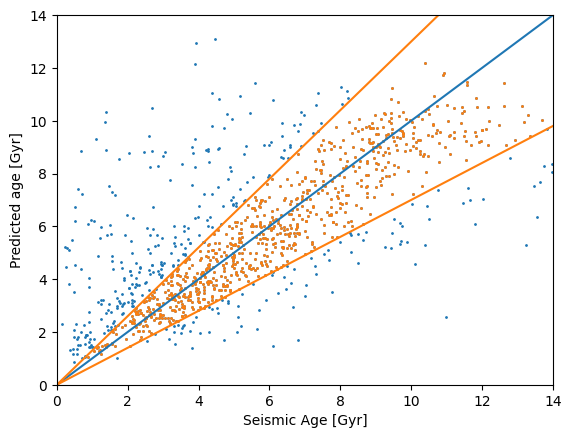

In [22]:
#remember that we scaled our input/output
plt.scatter( (y_test*scaling_y),(predictions*scaling_y), s=1.)
plt.scatter( (y_test[goodfit]*scaling_y),(predictions[goodfit]*scaling_y), s=1.)
plt.xlim(0.,14.)
plt.plot([0.,14.], [0.,14.])
plt.plot([14,0,14], [14*(1-metric), 0, 14*(1+metric)])

plt.ylabel(r'Predicted age [Gyr]')
plt.xlabel(r'Seismic Age [Gyr]')
plt.ylim(0,14)

In [23]:
int_mask = intersect[mask]
print(len(int_mask))
ind_a_mask = ind_a[mask]
apokasc3_ind_a = ind_a_mask #indices to use for prediction in apok2
print(len(ind_a_mask))
ind_b_mask = ind_b[mask]
print(len(ind_b_mask))
actual_age=agedata['Age'][ind_b_mask]
print(len(actual_age))
full_predict = model_apokasc3.predict(fullx)
print(len(full_predict))

11097
11097
11097
11097
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
11097


In [24]:
#for full dataset including training
#predicted_age = (full_predict * scaling_y).flatten()
#actual_age    = actual_age.flatten()
#metric = 0.3
#ratio = predicted_age / actual_age

#goodfit_full = np.where(((1 - metric) < predicted_age / actual_age) &
#                        ((1 + metric) > predicted_age / actual_age))

#badfit_full  = np.where(((1 - metric) > predicted_age / actual_age) |
#                        ((1 + metric) < predicted_age / actual_age))

#print('Full dataset evaluation:')
#print(len(goodfit_full[0]) / len(actual_age) * 100, 'percent of the ages are good')
#print(len(badfit_full[0]) / len(actual_age) * 100, 'percent of the ages are bad')

In [25]:
TIC_ids = data['tic_v8_id'][ind_a_mask]

In [26]:
#table with all ages for APOKASC3
#columns data_masked index (TIC_ids), actual APOKASC3 age (actual_age), predicted APOKASC3 age (full_predict)

predicted_age = (full_predict * scaling_y).flatten()
apokasc3_table = Table(
    [TIC_ids, actual_age, predicted_age],
    names=('TIC', 'actual_age', 'apokasc3_predicted_age'))

apokasc3_table

TIC,actual_age,apokasc3_predicted_age
int64,float64,float64
139037072,1.4097,1.882233089107275
139103680,1.1594,2.214693848955631
122784820,0.5842,2.1249271190643313
122784748,3.1325,4.466346713805199
137099544,2.8815,4.014846982705593
137146485,5.8519,5.680772845959663
137146582,9.1818,9.142843975424766
122784670,2.6495,4.696702172720433
137098997,0.4326,2.9948014059305192


### APOK2 Data

In [27]:
agedata= apok2
print('Answer: There are '+str(len(agedata))+' targets with ages in agedata.')

Answer: There are 4661 targets with ages in agedata.


In [28]:
#Option 4 APO-K2 Warfield et al. 2024
intersect, ind_a, ind_b = np.intersect1d(data_masked['sdss4_apogee_id'],agedata['APOGEE'], return_indices=True)

In [29]:
fullx = np.dstack([data_masked['teff'][ind_a],data_masked['logg'][ind_a], data_masked['m_h_atm'][ind_a],
                   data_masked['alpha_m_atm'][ind_a], data_masked['c_h'][ind_a], data_masked['n_h'][ind_a]])[0]

fully = np.dstack([agedata['Age'][ind_b]])[0]

#remove non-finite entries!
mask = np.all(np.isfinite(fullx), axis=1) & np.all(np.isfinite(fully), axis=1)
fullx, fully = fullx[mask], fully[mask]

scaling_x = np.median(fullx, axis=0)
scaling_y = np.median(fully, axis=0)

fullx, fully = fullx/scaling_x, fully/scaling_y
fullx_apok2 = fullx
fully_apok2 = fully
scale_x_apok2 = scaling_x
scale_y_apok2 = scaling_y

In [30]:

#start with an input layer
inputs = keras.Input(shape=(6,))
#now we add the Dense layers (indicating the previous layer in the brackets following the layer declaration

#change this part if you're changing the number of layers
layer1 =keras.layers.Dense(neurons_per_layer, activation='relu')(inputs)
layer2 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer1)
layer3 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer2)
layer4 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer3)
layer5 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer4)

#then the output layer YOU ALSO HAVE TO MAKE THIS MATCH YOUR NUMBER OF LAYERS
outputs = keras.layers.Dense(1)(layer5)


# then we put that all together in the Model object
model_apok2 = keras.Model(inputs=inputs, outputs=outputs, name='test')
#and we can print a summary to check it all went to plan
model_apok2.summary()

Model: "test"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20)             │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,841 (7.19 KB)

 Trainable params: 1,841 (7.19 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model_apok2.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [32]:
tenpercent=len(agedata['Age'][ind_b])//10 #figure out what ten percent of this set of age data is

#last name before M
trainbin=slice(0,-1*tenpercent-1)
testing=slice(-1*tenpercent,-1)


#last name M or later
#trainbin=slice(tenpercent+1,-1)
#testing=slice(0,tenpercent)


x_train, y_train = fullx[trainbin], fully[trainbin]
x_test, y_test = fullx[testing], fully[testing]

In [33]:
model_apok2.fit(x_train, y_train, epochs=iterations, validation_split=0.05, batch_size=300)

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0000e+00 - loss: 2.3214 - val_accuracy: 0.0000e+00 - val_loss: 1.9667
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0220e-04 - loss: 1.6412 - val_accuracy: 0.0049 - val_loss: 1.3427
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0038 - loss: 0.9363 - val_accuracy: 0.0049 - val_loss: 0.8676
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0104 - loss: 0.8075 - val_accuracy: 0.0049 - val_loss: 0.8195
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0084 - loss: 0.7092 - val_accuracy: 0.0049 - val_loss: 0.7604
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0103 - loss: 0.7082 - val_accuracy: 0.0049 - val_loss: 0.7135
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0094 - loss: 0.6028 - val_accuracy: 0.0049 - val_loss: 0.6613
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0072 - loss: 0.6222 - val_ac

In [34]:
predictions = model_apok2.predict(x_test)
print(len(predictions))

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
462


In [35]:
metric=0.3 #is the accuracy better than 30%?
goodfit=np.where(((1-metric) < predictions/y_test) & ((1+metric) > predictions/y_test))
badfit=np.where(((1-metric) > predictions/y_test) | ((1+metric) < predictions/y_test))

print ('APOK2: With ', neurons_per_layer, 'neurons per layer, ', layers, 'layers, and ', iterations, 'iterations')
print ('using the training set', trainbin)
print (len(goodfit[0])/len(y_test)*100, 'percent of the ages are good')
print (len(badfit[0])/len(y_test)*100, 'percent of the ages are bad')

APOK2: With  20 neurons per layer,  5 layers, and  200 iterations
using the training set slice(0, -464, None)
54.32900432900433 percent of the ages are good
45.67099567099567 percent of the ages are bad


(0.0, 14.0)

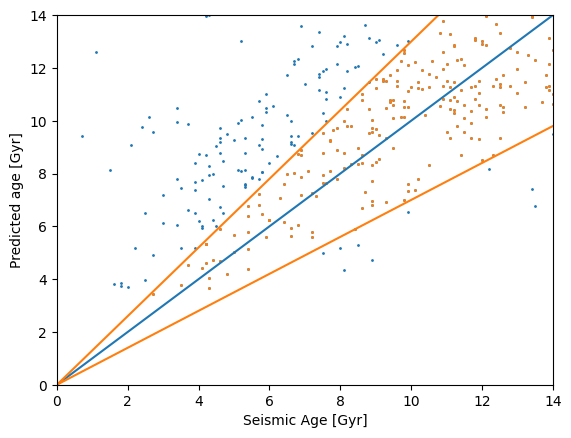

In [36]:
#remember that we scaled our input/output
plt.scatter( (y_test*scaling_y),(predictions*scaling_y), s=1.)
plt.scatter( (y_test[goodfit]*scaling_y),(predictions[goodfit]*scaling_y), s=1.)
plt.xlim(0.,14.)
plt.plot([0.,14.], [0.,14.])
plt.plot([14,0,14], [14*(1-metric), 0, 14*(1+metric)])

plt.ylabel(r'Predicted age [Gyr]')
plt.xlabel(r'Seismic Age [Gyr]')
plt.ylim(0,14)

In [37]:
int_mask = intersect[mask]
print(len(int_mask))
ind_a_mask = ind_a[mask]
apok2_ind_a = ind_a_mask #indices to use for prediction in apokasc3
print(len(ind_a_mask))
ind_b_mask = ind_b[mask]
print(len(ind_b_mask))
actual_age=agedata['Age'][ind_b_mask]
print(len(actual_age))
full_predict = model_apok2.predict(fullx)
print(len(full_predict))

4539
4539
4539
4539
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
4539


In [38]:
TIC_ids = data['tic_v8_id'][ind_a_mask]

In [39]:
#table with all ages for APOK2
#columns GAIA id (TIC_ids), actual APOK2 age (actual_age), predicted APOK2 age (full_predict)

predicted_age = (full_predict * scaling_y).flatten()
apok2_table = Table(
    [TIC_ids, actual_age, predicted_age],
    names=('TIC', 'actual_age', 'apok2_predicted_age'))

apok2_table

TIC,actual_age,apok2_predicted_age
,Gyr,
int64,float64,float64
318716683,9.9,9.993452835083007
272145408,2.0,8.16340570449829
272155400,5.5,10.347720336914062
272156521,0.5,0.9720279708504675
272156549,1.1,10.870544862747192
429035187,13.3,9.33136842250824
429035242,2.5,7.12476348876953
406408324,9.5,14.324440884590148


### Test Set Differences



We want a table that has the final columns:   
Apogee ID, actual age (some will have NAN values), apokasc3 predicted ages, apok2 predicted ages, age diff (apokasc3-apok2)

In [40]:
model_apokasc3
model_apok2

<Functional name=test, built=True>

In [41]:
good_x = np.dstack([
    data['teff'][good],
    data['logg'][good],
    data['m_h_atm'][good],
    data['alpha_m_atm'][good],
    data['c_h'][good],
    data['n_h'][good]])[0]

good_x_apokasc3 = good_x / scale_x_apokasc3
good_x_apok2    = good_x / scale_x_apok2

In [42]:
#run the apokasc3 for dr19
pred_apokasc3_good = model_apokasc3.predict(good_x_apokasc3)
len(pred_apokasc3_good)

13301/13301 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


425631

In [43]:
#run the apok2 model for dr19
pred_apok2_good = model_apok2.predict(good_x_apok2)
len(pred_apok2_good)

13301/13301 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


425631

In [44]:
TIC_id_good = data['tic_v8_id'][good]
len(TIC_id_good)

425631

In [45]:
#actual age
#actual_age_good = np.full(len(apogee_id_good), np.nan)

#APOKASC3
#id_to_age_apokasc3 = dict(zip(apokasc3_table['sdss4_apogee_id'], apokasc3_table['actual_age']))
#for i, apid in enumerate(apogee_id_good):
#    if apid in id_to_age_apokasc3:
#        actual_age_good[i] = id_to_age_apokasc3[apid]

#APOK2
#id_to_age_apok2 = dict(zip(apok2_table['sdss4_apogee_id'], apok2_table['actual_age']))
#for i, apid in enumerate(apogee_id_good):
#    if apid in id_to_age_apok2:
#        actual_age_good[i] = id_to_age_apok2[apid]

#len(actual_age_good)

In [46]:
pred_apokasc3_good_actual = pred_apokasc3_good * scale_y_apokasc3
pred_apok2_good_actual = pred_apok2_good * scale_y_apok2

In [47]:
pred_age_diff = pred_apok2_good_actual - pred_apokasc3_good_actual
len(pred_age_diff)

425631

In [48]:
TIC_id_good = np.array(TIC_id_good).flatten()
#actual_age_good = np.array(actual_age_good).flatten()
pred_apokasc3_good_actual = np.array(pred_apokasc3_good_actual).flatten()
pred_apok2_good_actual = np.array(pred_apok2_good_actual).flatten()
pred_age_diff = np.array(pred_age_diff).flatten()

In [49]:
apok2_apokasc3_table = Table(
    [TIC_id_good, pred_apok2_good_actual, pred_apokasc3_good_actual, pred_age_diff],
    names=('TIC', 'apok2_predicted_age', 'apokasc3_predicted_age', 'apok2_apokasc3_diff'))

apok2_apokasc3_table

TIC,apok2_predicted_age,apokasc3_predicted_age,apok2_apokasc3_diff
int64,float64,float64,float64
7167051,5.787159192562103,2.446101923310757,3.3410572692513463
130289670,6.264935863018035,2.7971271640777586,3.4678086989402765
391063280,5.69064120054245,1.6850304982602597,4.00561070228219
391138912,5.053191661834717,0.6385710076510906,4.414620654183626
130700676,5.356059896945953,2.5185569041728972,2.837502992773056
293618207,8.447119021415709,5.035263350629807,3.4118556707859025
346554265,5.999557328224181,4.896491265034675,1.1030660631895062
417853379,3.020935046672821,1.3960661345779897,1.6248689120948312
346457655,nan,nan,nan


In [50]:
mean_diff = np.nanmean(apok2_apokasc3_table['apok2_apokasc3_diff'])
print('The mean difference (APOK2 - APOKASC3) between models is '+str(mean_diff)+' Gyr')

The mean difference (APOK2 - APOKASC3) between models is 4.119625337461361 Gyr


In [51]:
apok2_apokasc3_table.write('Task9_apok2_apokasc3_table.csv', format='csv', overwrite=True)
#save the table